# Finding use cases for method comparison

... and for figures in paper

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-04-17T16:01:19.330072+02:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



In [2]:
import contextily as cx
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import pandas as pd
import shapely
from shapely.geometry import Point

import core  # noqa: F401
from core import utils

%watermark -w
%watermark -iv

Watermark: 2.5.0

pandas    : 2.2.3
geopandas : 1.0.1
folium    : 0.18.0
contextily: 1.6.2
matplotlib: 3.9.3
momepy    : 0.9.1
core      : 0.1.dev208+gcab4807.d20250225
shapely   : 2.0.6



In [3]:
# read in original data
# read in base data
meta = utils.read_sample_data()
meta = meta[meta.eFUA_name.isin(utils.city_fua.keys())].reset_index(drop=True)
meta

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry,continent,iso_a3
0,8989.0,4.0,11549;11569;11613;11618,Wuhan,1.0,CHN,China,2682.0,917.0,8.534061e+06,7.778941e+06,755120.113076,"POLYGON ((114.53263 30.60851, 114.52634 30.599...",Asia,CHN
1,1133.0,1.0,4417,Aleppo,1.0,SYR,Syria,1036.0,294.0,2.437709e+06,2.112719e+06,324989.970046,"POLYGON ((37.24042 36.36337, 37.25183 36.36337...",Asia,SYR
2,809.0,1.0,2850,Douala,1.0,CMR,Cameroon,360.0,224.0,3.002078e+06,2.965133e+06,36945.357264,"POLYGON ((9.60431 4.16656, 9.6143 4.16656, 9.6...",Africa,CMR
3,4617.0,1.0,670,Bucaramanga,1.0,COL,Colombia,342.0,92.0,1.054587e+06,9.526308e+05,101956.341187,"POLYGON ((-73.13881 7.24588, -73.12878 7.24588...",South America,COL
4,869.0,2.0,13129;13130,Auckland,1.0,NZL,NewZealand,2159.0,573.0,1.465958e+06,1.253144e+06,212814.292333,"POLYGON ((174.7203 -36.57421, 174.70887 -36.57...",Oceania,NZL
5,1656.0,1.0,2208,Liège,1.0,BEL,Belgium,2710.0,158.0,1.129392e+06,3.816731e+05,747718.680879,"POLYGON ((5.69383 50.88661, 5.68053 50.88661, ...",Europe,BEL
6,4881.0,1.0,193,Salt Lake City,1.0,USA,UnitedStates,1738.0,529.0,1.166374e+06,9.727146e+05,193659.830409,"POLYGON ((-111.91563 40.8034, -111.8919 40.803...",North America,USA


Finding FUA and city name for each use case

In [4]:
points = [Point(v["coords"]) for v in utils.use_cases.values()]
buffers = [v["buffer"] for v in utils.use_cases.values()]
cases = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
cases["buffer"] = buffers
cases["city_index"] = cases.geometry.apply(
    lambda x: meta.sindex.query(x, predicate="intersects")
)
cases["fua"] = cases.city_index.apply(lambda x: int(meta.iloc[x]["eFUA_ID"]))
cases["city"] = cases.city_index.apply(lambda x: meta.iloc[x[0]]["eFUA_name"])
cases = cases.drop(columns=["city_index"])
cases

/var/folders/66/3jkth_7d5gggg6pyr8yywwt40000gn/T/ipykernel_76386/1757689480.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cases["fua"] = cases.city_index.apply(lambda x: int(meta.iloc[x]["eFUA_ID"]))


,geometry,buffer,fua,city
0,POINT (9.81981 4.00249),220,809,Douala
1,POINT (9.82132 4.00986),100,809,Douala
2,POINT (37.06837 36.31436),200,1133,Aleppo
3,POINT (174.7512 -36.88972),100,869,Auckland
4,POINT (37.06599 36.31055),120,1133,Aleppo
5,POINT (9.74106 4.09687),80,809,Douala
6,POINT (37.1427 36.23658),30,1133,Aleppo
7,POINT (37.13986 36.24012),220,1133,Aleppo
8,POINT (5.63148 50.60589),110,1656,Liège
9,POINT (37.16807 36.19395),130,1133,Aleppo


In [5]:
# which methods to import
methods = [
    "original",
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "neatnet",
    "manual",
]

Read in data

In [6]:
### READ IN DATA

# initiate dicts
geoms = {}
projs = {}

# per city
for fua, city in utils.fua_city.items():
    print(city)

    geoms[city] = {}

    # poly = meta.loc[meta.eFUA_ID == fua, "geometry"]

    gdf_orig = utils.read_original(fua)
    proj_crs = gdf_orig.crs
    projs[fua] = proj_crs

    # per method
    for method in methods:
        print(f"\t {method}...")
        gdf = utils.read_results(fua, method, proj_crs)

        # Extract vertices
        _endpoint = lambda x, gdf=gdf: shapely.get_point(  # noqa: E731
            gdf.geometry.explode(ignore_index=True), x
        )

        # _endpoint = get_endpoint(gdf)
        _endpoints = pd.concat([_endpoint(0), _endpoint(-1)]).drop_duplicates()
        vertices = gpd.GeoDataFrame(geometry=_endpoints, crs=gdf.crs)

        geoms[city][method] = {}
        geoms[city][method]["lines"] = gdf.copy()
        geoms[city][method]["vertices"] = vertices.copy()

# add proj_crs info to cases table
cases["proj_crs"] = cases.fua.apply(lambda x: projs[x])

Aleppo
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Auckland
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Bucaramanga
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Douala
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Liège
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Salt Lake City
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Wuhan
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...


Make comparison plots

Use case 0


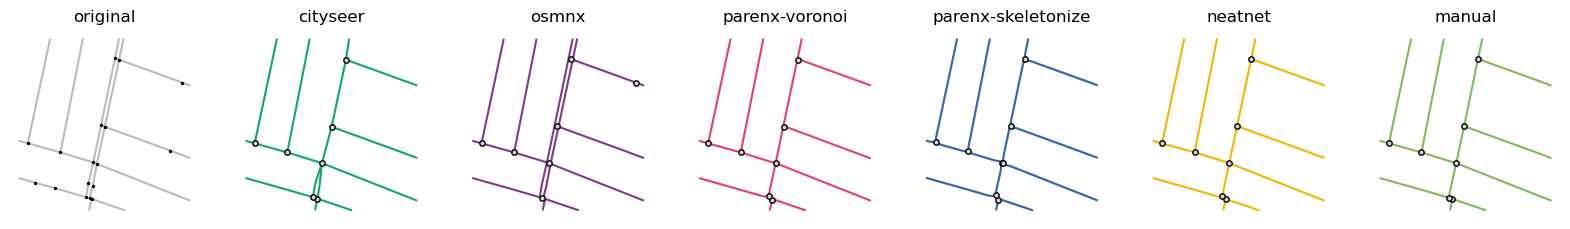

Use case 1


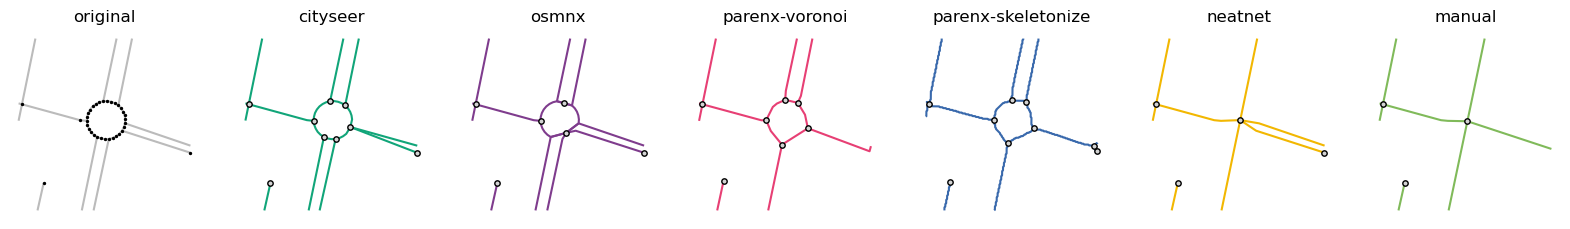

Use case 2


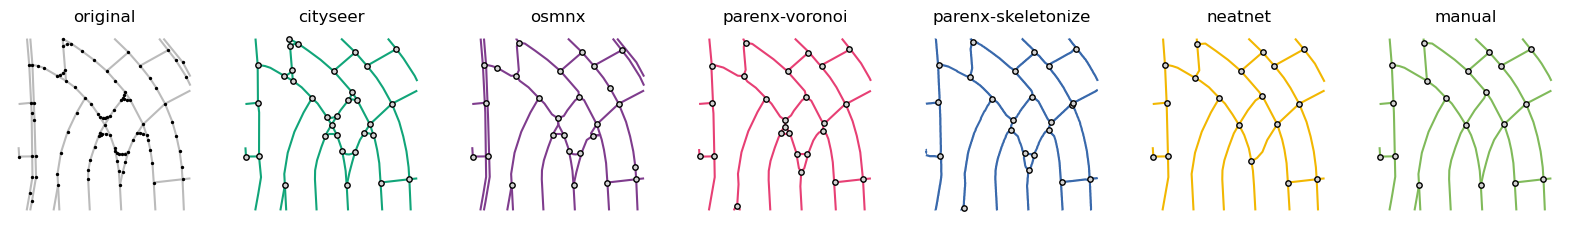

Use case 3


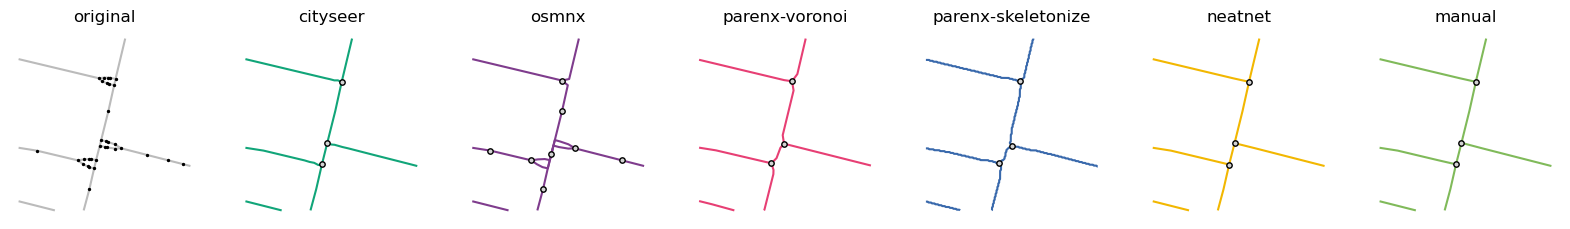

Use case 4


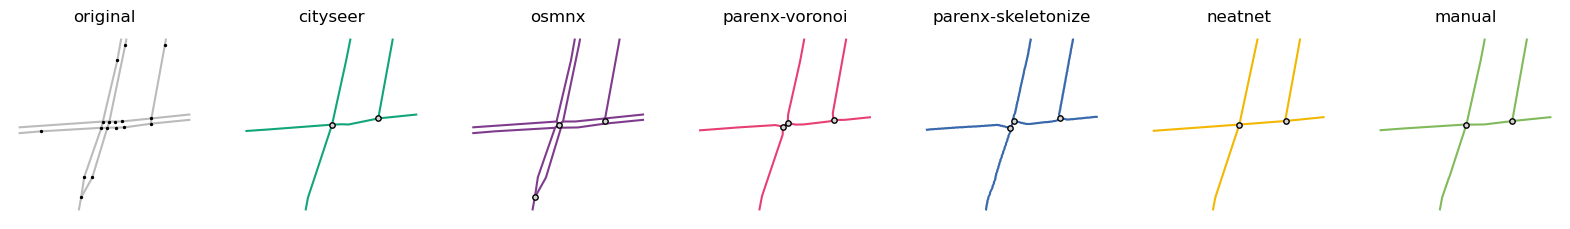

Use case 5


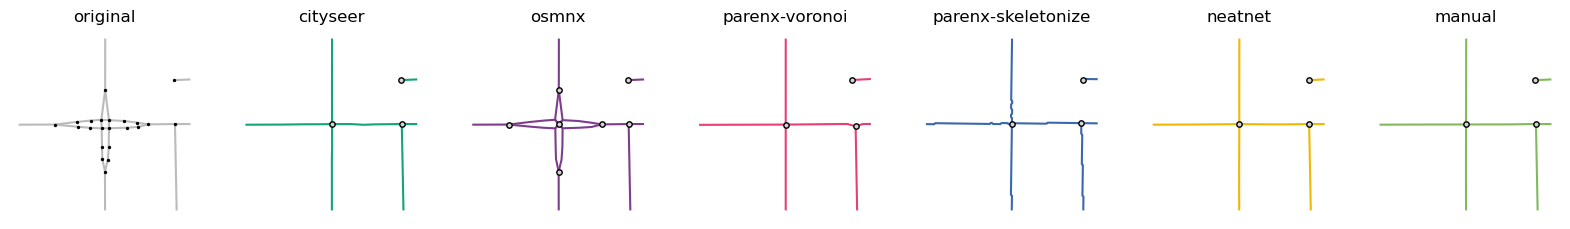

Use case 6


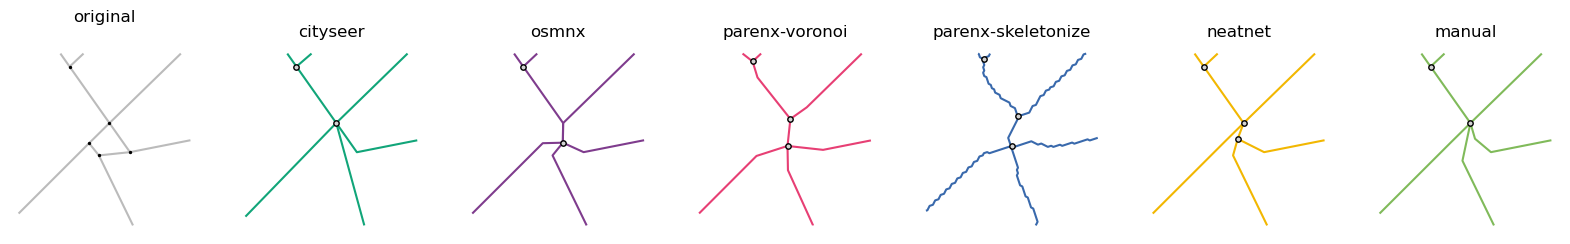

Use case 7


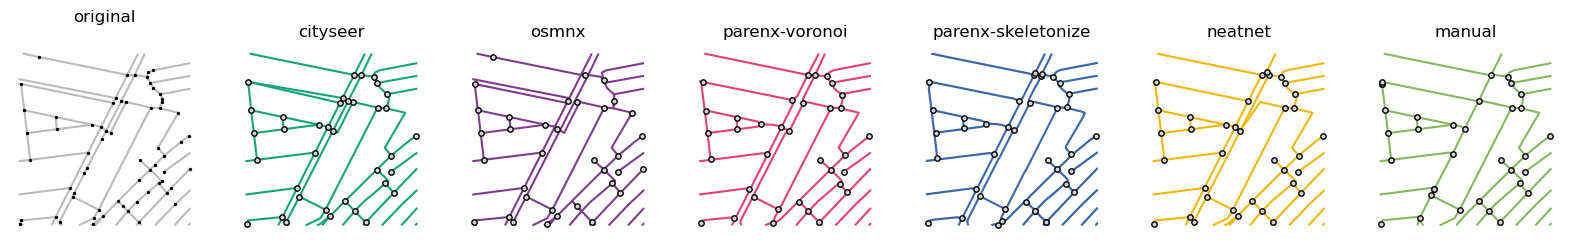

Use case 8


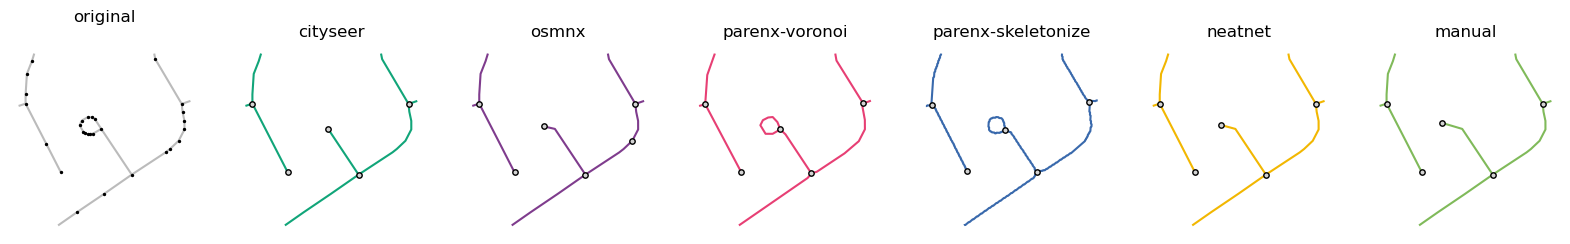

Use case 9


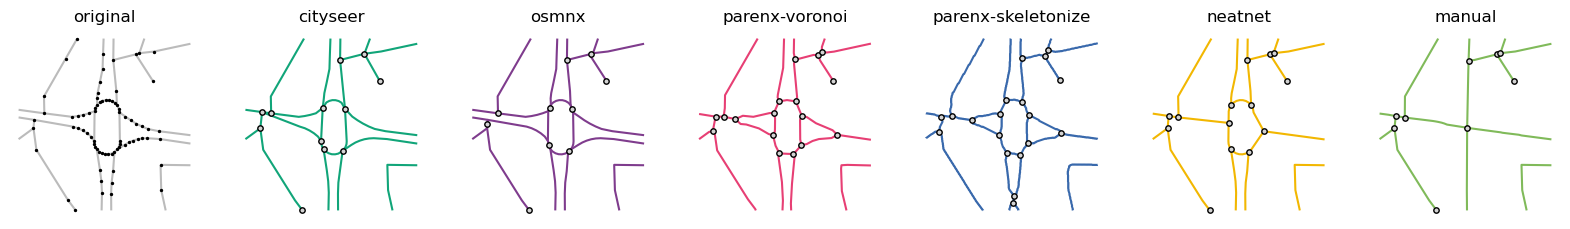

Use case 10


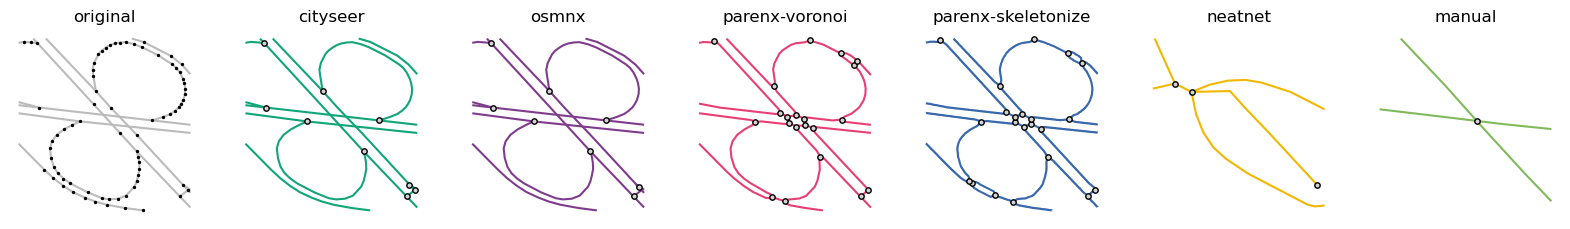

Use case 11


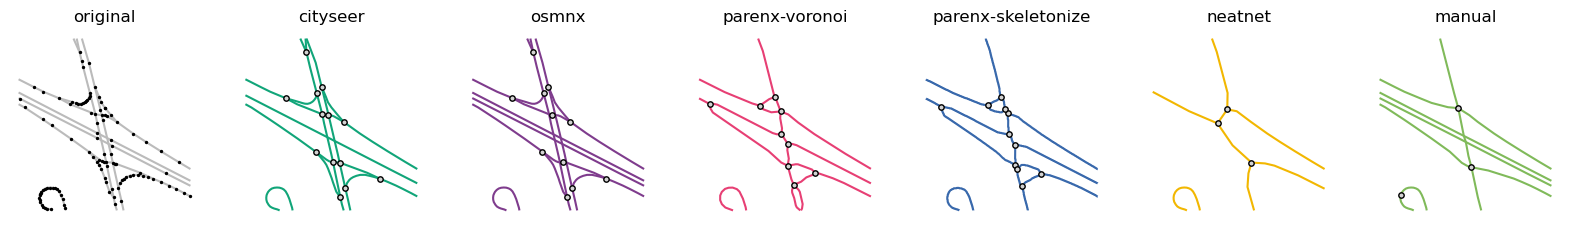

Use case 12


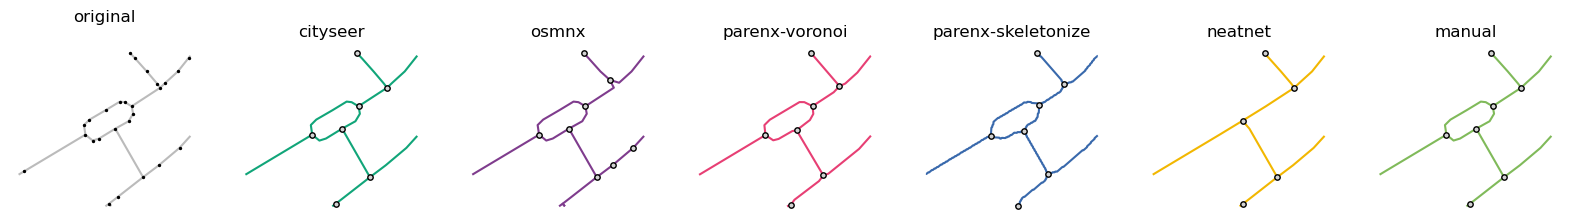

Use case 13


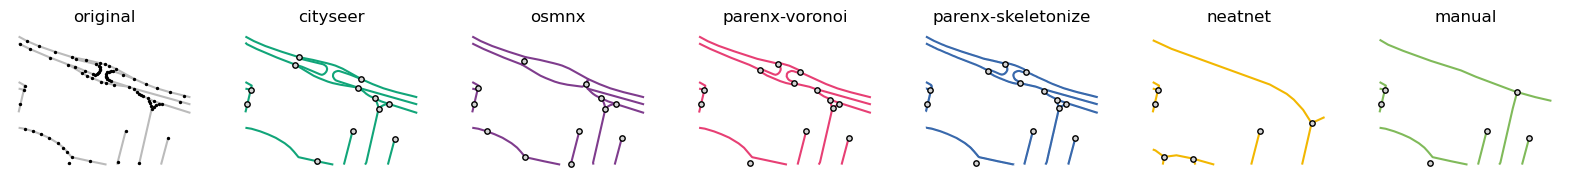

Use case 14


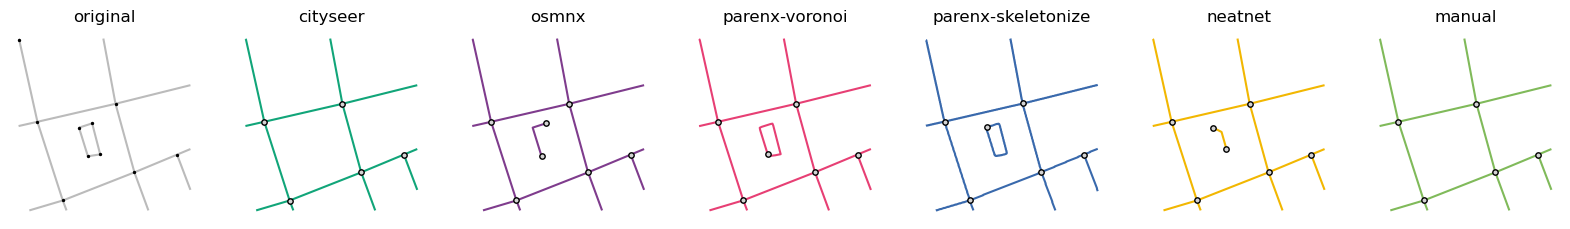

Use case 15


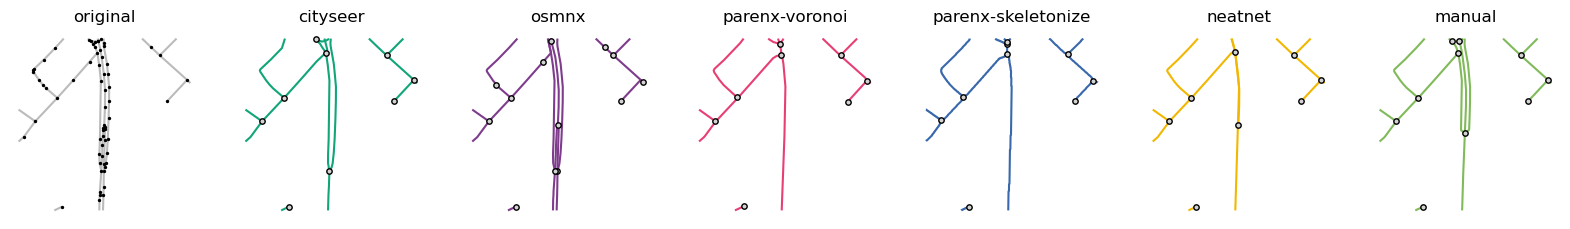

Use case 16


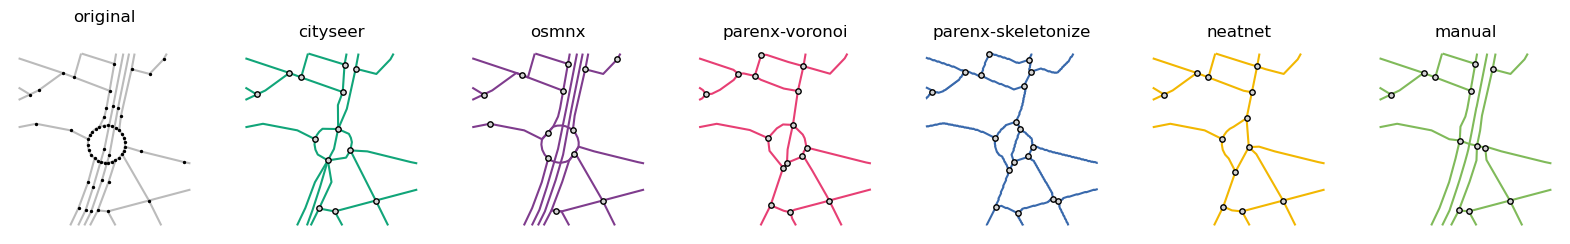

Use case 17


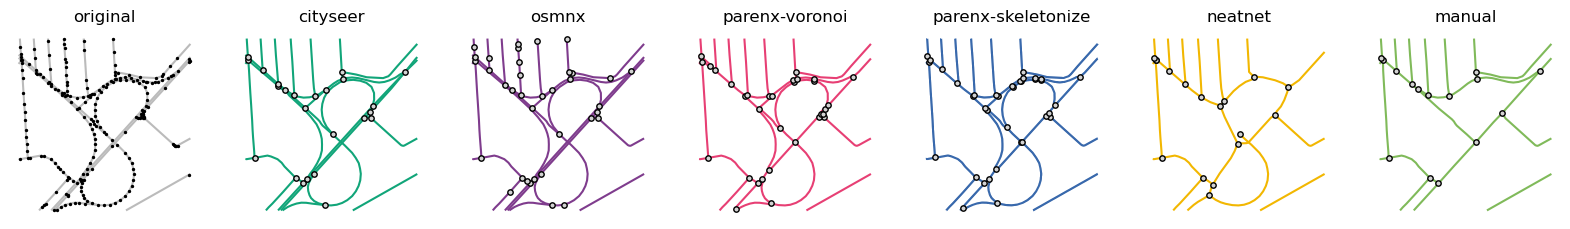

Use case 18


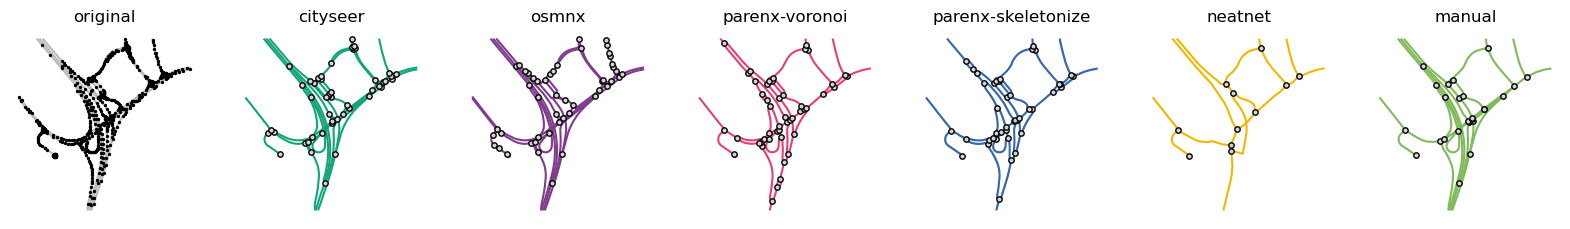

In [7]:
for i, mycase in cases.iterrows():
    print(f"Use case {i}")
    proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(mycase.proj_crs)
    myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)
    fig, axs = plt.subplots(1, len(methods), figsize=(20, 10), sharex=True, sharey=True)
    for ax, method in zip(axs, methods, strict=False):
        # print(mycase.city, method, i)
        lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
        vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
        lines.plot(
            ax=ax,
            linewidth=1.5,
            linestyle="-",
            zorder=1,
            color=utils.method_color[method],
        )
        if method == "original":
            mymarkersize = 2
            vertices.plot(
                ax=ax, facecolor="k", edgecolor="k", markersize=mymarkersize, zorder=2
            )

        else:
            mymarkersize = 15
            vertices.plot(
                ax=ax,
                facecolor="lightgrey",
                edgecolor="k",
                markersize=mymarkersize,
                zorder=2,
            )
        ax.set_axis_off()
        ax.set_title(method)
    plt.show()